## Assigment 2: Word2vec and CBOW ⚡

---




In this assignment, we will guide you through the process of implementing Continous Bag Of Words (CBOW) using PyTorch, providing step-by-step instructions, code snippets, and explanations to aid your understanding. By the end of this assignment, you will have a solid grasp of Word2Vec's mechanics and be equipped to apply this knowledge to a wide range of NLP tasks.

Let's embark on this journey to unlock the power of word embeddings with Word2Vec and PyTorch!

This [guide](https://pytorch.org/tutorials/beginner/basics/intro.html) might come in handy to understand how Pytorch works.

Let's start by installing the needed libraries

In [ ]:
!pip install datasets
!gdown https://drive.google.com/file/d/1-mB6idLW5Jg4aE68jOj5NDcDxRNlMXpu/view?usp=sharing --fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1-mB6idLW5Jg4aE68jOj5NDcDxRNlMXpu
To: /content/TestSet_sample.csv
100% 51.5k/51.5k [00:00<00:00, 52.1MB/s]


In this assigment we will use the data set wikitext. This dataset is composed of textual content extracted from Wikipedia articles which hopefully will lead to good embeddings when input in CBOW.

In [ ]:
from datasets import load_dataset
from random import sample

wikitext = load_dataset("wikipedia", "20220301.simple")
trim_dataset= sample(wikitext['train']['text'],5000)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

wikipedia.py:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


train-00000-of-00001.parquet:   0%|          | 0.00/134M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/205328 [00:00<?, ? examples/s]

Let's have a look at a datapoint.

In [ ]:
trim_dataset[0]

"{{Automatic taxobox\n|image = Illustration Ceratonia siliqua0.jpg\n|image_caption = Carob tree (Ceratonia siliqua)\n|taxon = Ceratonia\n|authority = L.\n|subdivision_ranks = Species\n|subdivision = Selected species\nCeratonia oreothauma\n†Ceratonia emarginataCeratonia siliqua}}Ceratonia is small genus of flowering trees in the pea family, Fabaceae, endemic to the Mediterranean region and the Middle East.  Its best known member, the carob tree, is cultivated for its fruits (called pods) and has been widely introduced to regions with similar climates.\n\nIt belongs to the subfamily Caesalpinioideae.\n\nThe genus was created by Carl Linnaeus and published in Species Plantarum 2: 1026 en 1753.Ceratonia in PlantList The type specimen is Ceratonia siliqua.\n\nThe genus was long considered monotypic (with only one species), but a second species, Ceratonia  oreothauma, was identified in 1979 from Oman and Somalia.\n\nImages\nSome photos of Ceratonia siliqua'' (the carob tree):\n\nReferences\n

As you can see there are a lot of numeric values, end-of-lines and the word "References" at the end. We saw in the previous assigment how preprocessing can significantly reduce the vocabulary; feel free to base the following code in your previous work.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import string
import re
from nltk.corpus import stopwords
def preprocess_data(data):
  """ Method to clean text from noise and standarize text across the different classes.
      The preprocessing includes converting to joining all datapoints, lowercase, removing punctuation, and removing stopwords.
  Arguments
  ---------
  text : List of String
     Text to clean
  Returns
  -------
  text : String
      Cleaned and joined text
  """

  stop_words = set(stopwords.words('english'))

  text = ' '.join(data) #join all text in one single string
  text = text.lower() #make everything lower case
  text = text.replace('\n', ' ') #remove \n characters
  text = text.replace('references', '') #remove word "References"
  text = text.translate(str.maketrans('', '', string.punctuation)) #remove any punctuation or special characters
  text = re.sub(r'\d+', '', text) #remove all numbers
  text = ' '.join(word for word in text.split() if word not in stop_words) #remove all stopwords (see imports to help you with this)

  return text

text=preprocess_data(trim_dataset)

Our `text` variable includes all the data in just one string. Let's create a dictionary of frequencies for more pre-processing (same as in the last assigment).

In [ ]:
def vocab_frequency(text):
  """ Creates dictionary of frequencies based on a dataset.
  Arguments
  ---------
  dataset : list of tuples
      list of tuples of the form (label, text)
  Returns
  -------
  vocab_dict : dictonary
      Dictionary of words and their frequencies with the format {word: frequency}
  """
  vocab_dict = {}
  # Split the text into words
  words = text.split()

  # Count the frequency of each word
  for word in words:
      if word in vocab_dict:
          vocab_dict[word] += 1
      else:
          vocab_dict[word] = 1
  return vocab_dict


vocabulary = vocab_frequency(text)

In [ ]:
len(vocabulary)

59352

Now our vocabulary is ready 😎

Since our neural networks can't understand strings we have to turn these strings into integers. In this case, we can use the vocabulary index to represent the words, so we will need the mapping: word -> index

In [ ]:
import torch
import torch.nn as nn
def word_to_index(vocabulary):
  """ Method to create vocabulary to index mapping.
  Arguments
  ---------
  vocabulary : Dictionary
     Dictonary of format {word:frequency}
  Returns
  -------
  word_to_index : Dictionary
      Dictionary mapping words to index with format {word:index}
  """
  word_to_index = {}
  #Create key,value pair for out of vocabulary worlds


  # Create mapping from word to index
  for index, word in enumerate(vocabulary.keys()):
      word_to_index[word] = index

  # Optionally, add an index for out-of-vocabulary words
  word_to_index["<OOV>"] = 0  # Assign an index for OOV words

  return word_to_index  # Return the dictionary

word_to_index = word_to_index(vocabulary)


Let's start to get more on topic. If you remember, Word2Vec has a specific way of generating each vector.
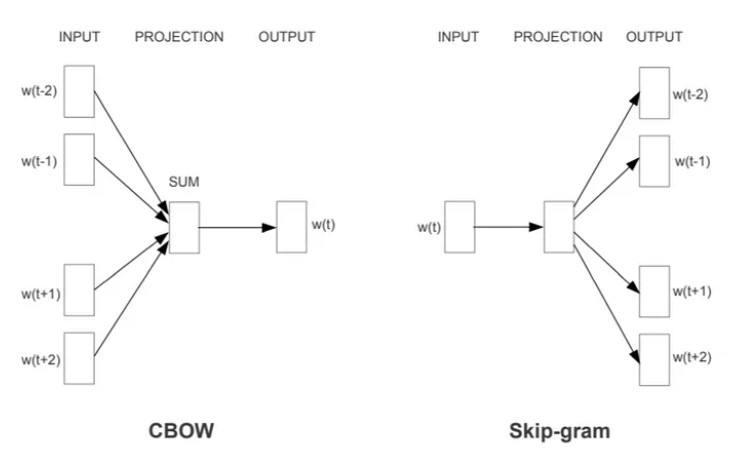

The embedding is based on the surrounding words (before and after) taken as context. In the case of CBOW, we input the surrounding words to our neural network and expect that it predicts the middle word. Let's format our dataset to meet the needs of the neural network.


In [ ]:
def generate_dataset(data, window_size,word_to_index):
  """ Method to generate training dataset for CBOW.
  Arguments
  ---------
  data : String
     Training dataset
  window_size : int
     Size of the context window
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  surroundings : N x W Tensor
      Tensor with index of surrounding words, with N being the number of samples and W being the window size
  targets : Tensor
      Tensor with index of target word
  """
  surroundings= []
  targets = []
  data= data.split(" ")
  #TODO complete function
  for i in range(window_size,len(data)-window_size):
    surrounding = [word_to_index[data[j]] for j in range(i - window_size, i)] + \
                      [word_to_index[data[j]] for j in range(i + 1, i + window_size + 1)] #get surrounding words based on window size
    target = word_to_index[data[i]] #get target word (middle word)

    #append to surrounding
    surroundings.append(surrounding)

    #append to targets
    targets.append(target)

  # Convert to tensors
  surroundings_tensor = torch.tensor(surroundings)
  targets_tensor = torch.tensor(targets)

  return surroundings_tensor, targets_tensor

t_surroundings, t_targets = generate_dataset(text,2,word_to_index)

With our dataset ready we can finally create our Neural Network. The idea is to replicate what Mikolov did in 2013 (see slides of Word2Vec).

In [ ]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, embed_dim=300):
    """ Class to define the CBOW model
    Attributes
    ---------
    device : device
      Device where the model will be trained (gpu preferably)
    vocab_size : int
      Size of the vocabulary
    embed_dim : int
      Size of the embedding layer
    hidden_dim : int
      Size of the hidden layer
    """
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim) #use this layer to get a vector from the the word index
    self.linear = nn.Linear(embed_dim, vocab_size) #first fully connected layer (bottleneck)

  def forward(self, x):
    emb = self.embedding(x) #pass input through embedding layer
    average = emb.mean(dim=1) #average and resize (size must be batch_size x embed_dim)
    out = self.linear(average) #pass through linear layer

    return out

In [ ]:
from torch.utils.data import DataLoader
#creation of dataloader for training
train_dataloader=DataLoader(list(zip(t_surroundings,t_targets)),batch_size=64,shuffle=True) #Here please change batch size depending of your GPU capacities (if GPU runs out of memory lower batch_size)

In [ ]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG
model = CBOW(len(word_to_index)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

#BE PATIENT: This code can take up to 2 hours and 10 min for a batch size of 64 and 10 epochs
for epoch in range(epochs):
    total_loss = 0
    i=0
    for surr, tar in tqdm(train_dataloader):
        #TODO: create code for training our model
        #print(i)
        #i+=1
        surr, tar = surr.to(device), tar.to(device)
        optimizer.zero_grad()

        log_probs = model(surr)

        loss= loss_function(log_probs,tar)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} loss: {total_loss/len(train_dataloader)}")

100%|██████████| 7414/7414 [01:46<00:00, 69.77it/s]


Epoch 1 loss: 8.816421085012419


100%|██████████| 7414/7414 [01:45<00:00, 70.59it/s]


Epoch 2 loss: 6.640207530515098


100%|██████████| 7414/7414 [01:44<00:00, 70.81it/s]


Epoch 3 loss: 5.41547159962748


100%|██████████| 7414/7414 [01:44<00:00, 70.82it/s]


Epoch 4 loss: 4.498384988980053


100%|██████████| 7414/7414 [01:44<00:00, 70.75it/s]


Epoch 5 loss: 3.769624163270286


100%|██████████| 7414/7414 [01:45<00:00, 70.59it/s]


Epoch 6 loss: 3.1949940488317248


100%|██████████| 7414/7414 [01:45<00:00, 70.61it/s]


Epoch 7 loss: 2.754824527309434


100%|██████████| 7414/7414 [01:44<00:00, 70.62it/s]


Epoch 8 loss: 2.4112779955546233


100%|██████████| 7414/7414 [01:44<00:00, 70.74it/s]


Epoch 9 loss: 2.1274200863905084


100%|██████████| 7414/7414 [01:44<00:00, 70.65it/s]

Epoch 10 loss: 1.8844805643794542


## Let's test it! 🤓

Now that we hopefully have good embeddings we can put them to the test. Let's start by creating some useful functions.

In [ ]:
def get_embedding(word, model, word_to_index):
  """ Method to get the embedding vector for a given word.
  Arguments
  ---------
  word : String
     Word given
  model : NN.module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  word_embedding : Tensor
      Embedding vector for the given word
    """
  index = word_to_index.get(word) # get word index

  if index is None:
        raise ValueError(f"Word '{word}' not found in vocabulary.")

  with torch.no_grad():
        embedding_weights = model.embedding.weight # Get the weights of the embedding layer
        embedding_weights.requires_grad = False
        word_embedding = embedding_weights[index] # Extract the embedding vector for the given word index

  return word_embedding

embedding_vector = get_embedding("shot",model,word_to_index) #test this code by getting embedding of the word "shot"
print(embedding_vector)

tensor([-1.1250,  0.7289, -2.3062, -0.8020, -0.8879,  1.0068, -0.8059,  0.3553,
        -0.4304,  0.7376, -0.1659, -0.1046,  0.8330, -1.7762, -1.1292,  0.6825,
        -0.4016, -2.3079,  0.9208,  0.9848, -0.9744,  2.0939,  1.5012,  0.4173,
        -1.2323,  0.9314,  1.5685,  2.0754,  1.5238,  0.8522, -2.1207, -0.9463,
         1.3152,  0.9729, -0.4051, -1.1479,  2.1938,  0.6212, -0.9881,  0.7382,
         1.1614, -0.1253, -0.4159,  2.4124, -0.7631, -0.8080, -0.3414, -1.0156,
        -1.3249, -0.3802,  1.3530,  1.8448, -0.2473, -0.4123,  0.6171, -0.4131,
         0.8902, -0.0944,  1.9457, -1.5909,  0.9019, -2.5672,  1.5945, -1.0023,
        -0.7098,  0.4993,  1.9160,  0.2033, -0.1213, -1.8484, -0.6388, -0.5200,
         1.0770, -0.5198,  0.1699, -0.9453,  0.0655,  0.2879, -0.1977, -0.5351,
        -0.9823,  0.1522, -0.4236,  0.7743, -1.3187, -0.1829, -0.7780,  0.2787,
        -0.6896, -0.9099, -0.7142, -0.2005, -0.7597, -1.8233, -0.6075, -0.8691,
        -0.2079,  3.3055,  2.2187, -0.92

In [ ]:
def cosine_similarity(v1,v2):
  """ Method to calculate cosine similarity between two vectors.
  Arguments
  ---------
  v1 : Tensor
     First vector
  v2 : Tensor
     Second vector
  Returns
  -------
  cosine_similarity : float
      Cosine similarity between v1 and v2
  """
  #TODO create expression to calculate cosine similarity

  # Compute the dot product
  dot_product = torch.dot(v1, v2)

  # Compute the norms (magnitudes) of the vectors
  norm_v1 = torch.norm(v1)
  norm_v2 = torch.norm(v2)

  # Calculate cosine similarity
  cosine_similarity = dot_product / (norm_v1 * norm_v2)

  return cosine_similarity.item()

In [ ]:
def get_k_nearest_words(k, result, vocabulary, model, word_to_index):
  """ Method to find the k nearest words of a given vector
  Arguments
  ---------
  k : int
      Number of nearest words to return
  result : torch.Tensor
      Embedding vector for the given word
  vocabulary : Dictionary
      Dictionary mapping words to frequency with format {word:frequency}
  model : NN.module
      CBOW model
  word_to_index : Dictionary
      Dictionary mapping words to index with format {word:index}
  Returns
  -------
  similar : List of Strings
      List of k nearest words to the given word
  """
  similarity_scores = torch.zeros(len(word_to_index), device=result.device)

  # Calculate similarity scores for all words in the vocabulary
  for idx, word in enumerate(word_to_index.keys()):
      vocab_embedding = get_embedding(word, model, word_to_index)  # Get embedding for each word
      similarity_scores[idx] = cosine_similarity(result, vocab_embedding)  # Compute similarity

  k_first = torch.topk(similarity_scores, k)  # Get indices of top k similar words
  similar = [list(word_to_index.keys())[idx] for idx in k_first.indices]  # Extract the words based on the indices

  return similar


The Google analogy test set is a state of the art data set for word embeddings that tests their ability to solve analogy tasks. A well-known example for it is: "king is to man as queen is to women." We will use a subset of this dataset to see how our CBOW model performs.


In [ ]:
import pandas as pd

def test_analogy(model, word_to_index, analogy_file):
  """ Method to test accuracy of CBOW embeddings on analogy tasks.
  Arguments
  ---------
  mode : nn.Module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  analogy_file : String
     File containing analogy tasks
  Returns
  -------
  accuracy : float
      accuracy of the model on the analogy tasks
  """
  df = pd.read_csv(analogy_file)
  df = df[df.category=='capital-common-countries'] #using capital cities subset of test set
  correct = 0
  total = 0

  for index, row in df.iterrows():
    word_one = row['word_one'].lower()  # Extract word number 1
    word_two = row['word_two'].lower()  # Extract word number 2
    word_three = row['word_three'].lower()  # Extract word number 3
    word_four = row['word_four'].lower()  # Extract word number 4

    #remember to standarize the words by using .lower

    #create exception in case word is not in vocabulary
    if word_one not in word_to_index or word_two not in word_to_index or word_three not in word_to_index:
      continue  # Skip this iteration if any word is not in the vocabulary

    #get embedding of all words
    embedding_word_1 = get_embedding(word_one, model, word_to_index)
    embedding_word_2 = get_embedding(word_two, model, word_to_index)
    embedding_word_3 = get_embedding(word_three, model, word_to_index)

    result = embedding_word_2 - embedding_word_1 + embedding_word_3
    prediction = get_k_nearest_words(10, result, word_to_index, model, word_to_index) #call the k_nearest function (set k to 10)

    #if word_four is in prediction, add one to correct
    if word_four in prediction:
      correct += 1

    total+=1
  if total != 0:
    accuracy=correct/total
  else:
    return 'No word was found in the embeddings '
  return accuracy

test_analogy(model,word_to_index,'TestSet_sample.csv')

0.0

Our model can do much better! In the "Let's experiment" part we will try to improve this model. Also depending on your GPU accesibility you can train for more epochs and data (making trim_dataset bigger in cell #3).

TSNE can be a very helpful and cool visualization method of our vectors, this way we can clearly see the relationship between different words (maybe even find some clusters!). Let's implement this visualization.

In [ ]:
import numpy as np
import pandas as pd
import torch
import sys

from sklearn.manifold import TSNE
import plotly.graph_objects as go

tsne = TSNE(n_components=2, random_state=42) #create TSNE
embeddings = model.embedding.weight.detach().cpu().numpy()[:1000] #get embeddings by detaching weights of embedding layer (use only first 1000 words)
#TODO create TSNE plot to visualize the relationship between our vectors

# Create a t-SNE representation
tsne_results = tsne.fit_transform(embeddings)

# Prepare data for Plotly
x = tsne_results[:, 0]
y = tsne_results[:, 1]

# Get the corresponding words for the first 1000 embeddings
words = list(word_to_index.keys())[:1000]

# Create a scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers+text',
    text=words,
    textposition="top center",
    marker=dict(size=5, opacity=0.7),
))

fig.update_layout(
    title="t-SNE Visualization of Word Embeddings",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
)

# Show the plot
fig.show()

## Let's Experiment!

Now it's your time to experiment.
- Find a new training corpus to train our CBOW model from scratch (it can be books, tweets, etc).  This should change the embeddings. Analyse and report how this new training set changes the vectors themselves and the accuracy on the analogy test.
- Test your embeddings on a different sub-section of the analogy dataset or another dataset. Analyse and report how these results compare with the original dataset.

In [ ]:
!pip install datasets
!gdown https://drive.google.com/file/d/1-mB6idLW5Jg4aE68jOj5NDcDxRNlMXpu/view?usp=sharing --fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1-mB6idLW5Jg4aE68jOj5NDcDxRNlMXpu
To: /content/TestSet_sample.csv
100% 51.5k/51.5k [00:00<00:00, 67.3MB/s]


In [ ]:
import torch
torch.manual_seed(0)

In [ ]:
# 1. Data Loading and Preprocessing
from nltk.corpus import gutenberg
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import pandas as pd
import torch.nn.functional as F
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('gutenberg')

# Load Gutenberg corpus
books = ['austen-emma.txt', 'shakespeare-hamlet.txt', 'melville-moby_dick.txt']
new_corpus = []
for book in books:
    new_corpus.extend(gutenberg.words(book))
text = " ".join([word.lower() for word in new_corpus])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [ ]:
text

'[ emma by jane austen 1816 ] volume i chapter i emma woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her . she was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister \' s marriage , been mistress of his house from a very early period . her mother had died too long ago for her to have more than an indistinct remembrance of her caresses ; and her place had been supplied by an excellent woman as governess , who had fallen little short of a mother in affection . sixteen years had miss taylor been in mr . woodhouse \' s family , less as a governess than a friend , very fond of both daughters , but particularly of emma . between _them_ it was more the intimacy of sisters . even before miss taylor had ceased to hold the nominal office of go

In [ ]:
import string
import re
from nltk.corpus import stopwords
def preprocess_data(data):
  """ Method to clean text from noise and standarize text across the different classes.
      The preprocessing includes converting to joining all datapoints, lowercase, removing punctuation, and removing stopwords.
  Arguments
  ---------
  text : List of String
     Text to clean
  Returns
  -------
  text : String
      Cleaned and joined text
  """

  stop_words = set(stopwords.words('english'))

  #text = ' '.join(data) #join all text in one single string
  #text = text.lower() #make everything lower case
  text = data.replace('\n', ' ') #remove \n characters
  text = text.replace('references', '') #remove word "References"
  text = text.translate(str.maketrans('', '', string.punctuation)) #remove any punctuation or special characters
  text = re.sub(r'\d+', '', text) #remove all numbers
  text = ' '.join(word for word in text.split() if word not in stop_words) #remove all stopwords (see imports to help you with this)

  return text

text=preprocess_data(text)

In [ ]:
def vocab_frequency(text):
  """ Creates dictionary of frequencies based on a dataset.
  Arguments
  ---------
  dataset : list of tuples
      list of tuples of the form (label, text)
  Returns
  -------
  vocab_dict : dictonary
      Dictionary of words and their frequencies with the format {word: frequency}
  """
  vocab_dict = {}
  # Split the text into words
  words = text.split()

  # Count the frequency of each word
  for word in words:
      if word in vocab_dict:
          vocab_dict[word] += 1
      else:
          vocab_dict[word] = 1
  return vocab_dict


vocabulary = vocab_frequency(text)

In [ ]:
len(vocabulary)

21556

In [ ]:
vocabulary

{'emma': 865,
 'jane': 301,
 'austen': 1,
 'volume': 17,
 'chapter': 229,
 'woodhouse': 314,
 'handsome': 41,
 'clever': 28,
 'rich': 25,
 'comfortable': 43,
 'home': 194,
 'happy': 136,
 'disposition': 32,
 'seemed': 424,
 'unite': 9,
 'best': 162,
 'blessings': 6,
 'existence': 15,
 'lived': 38,
 'nearly': 48,
 'twenty': 66,
 'one': 1425,
 'years': 154,
 'world': 283,
 'little': 623,
 'distress': 22,
 'vex': 1,
 'youngest': 5,
 'two': 499,
 'daughters': 12,
 'affectionate': 13,
 'indulgent': 2,
 'father': 284,
 'consequence': 38,
 'sister': 47,
 'marriage': 43,
 'mistress': 13,
 'house': 143,
 'early': 52,
 'period': 36,
 'mother': 130,
 'died': 25,
 'long': 496,
 'ago': 69,
 'indistinct': 1,
 'remembrance': 13,
 'caresses': 1,
 'place': 215,
 'supplied': 17,
 'excellent': 57,
 'woman': 149,
 'governess': 9,
 'fallen': 11,
 'short': 135,
 'affection': 57,
 'sixteen': 16,
 'miss': 603,
 'taylor': 49,
 'mr': 1217,
 'family': 89,
 'less': 121,
 'friend': 215,
 'fond': 47,
 'particularly

In [ ]:
import torch
import torch.nn as nn
def word_to_index(vocabulary):
  """ Method to create vocabulary to index mapping.
  Arguments
  ---------
  vocabulary : Dictionary
     Dictonary of format {word:frequency}
  Returns
  -------
  word_to_index : Dictionary
      Dictionary mapping words to index with format {word:index}
  """
  word_to_index = {}
  #Create key,value pair for out of vocabulary worlds


  # Create mapping from word to index
  for index, word in enumerate(vocabulary.keys()):
      word_to_index[word] = index

  # Optionally, add an index for out-of-vocabulary words
  word_to_index["<OOV>"] = len(word_to_index)  # Assign an index for OOV words

  return word_to_index  # Return the dictionary

word_to_index = word_to_index(vocabulary)


In [ ]:
def generate_dataset(data, window_size,word_to_index):
  """ Method to generate training dataset for CBOW.
  Arguments
  ---------
  data : String
     Training dataset
  window_size : int
     Size of the context window
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  surroundings : N x W Tensor
      Tensor with index of surrounding words, with N being the number of samples and W being the window size
  targets : Tensor
      Tensor with index of target word
  """
  surroundings= []
  targets = []
  data= data.split(" ")
  #TODO complete function
  for i in range(window_size,len(data)-window_size):
    surrounding = [word_to_index[data[j]] for j in range(i - window_size, i)] + \
                      [word_to_index[data[j]] for j in range(i + 1, i + window_size + 1)] #get surrounding words based on window size
    target = word_to_index[data[i]] #get target word (middle word)

    #append to surrounding
    surroundings.append(surrounding)

    #append to targets
    targets.append(target)

  # Convert to tensors
  surroundings_tensor = torch.tensor(surroundings)
  targets_tensor = torch.tensor(targets)

  return surroundings_tensor, targets_tensor

t_surroundings, t_targets = generate_dataset(text,2,word_to_index)

In [ ]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, embed_dim=300):
    """ Class to define the CBOW model
    Attributes
    ---------
    device : device
      Device where the model will be trained (gpu preferably)
    vocab_size : int
      Size of the vocabulary
    embed_dim : int
      Size of the embedding layer
    hidden_dim : int
      Size of the hidden layer
    """
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim) #use this layer to get a vector from the the word index
    self.linear = nn.Linear(embed_dim, vocab_size) #first fully connected layer (bottleneck)

  def forward(self, x):
    emb = self.embedding(x) #pass input through embedding layer
    average = emb.mean(dim=1) #average and resize (size must be batch_size x embed_dim)
    out = self.linear(average) #pass through linear layer

    return out

In [ ]:
from torch.utils.data import DataLoader
#creation of dataloader for training
train_dataloader=DataLoader(list(zip(t_surroundings,t_targets)),batch_size=64,shuffle=True) #Here please change batch size depending of your GPU capacities (if GPU runs out of memory lower batch_size)

In [ ]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG
model = CBOW(len(word_to_index)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

for epoch in range(epochs):
    total_loss = 0
    i=0
    for surr, tar in tqdm(train_dataloader):
        #TODO: create code for training our model
        #print(i)
        #i+=1
        surr, tar = surr.to(device), tar.to(device)
        optimizer.zero_grad()

        log_probs = model(surr)

        loss= loss_function(log_probs,tar)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} loss: {total_loss/len(train_dataloader)}")

100%|██████████| 3120/3120 [00:18<00:00, 167.54it/s]


Epoch 1 loss: 8.62875836950082


100%|██████████| 3120/3120 [00:17<00:00, 177.30it/s]


Epoch 2 loss: 6.912924553950628


100%|██████████| 3120/3120 [00:17<00:00, 181.89it/s]


Epoch 3 loss: 5.750473301532941


100%|██████████| 3120/3120 [00:17<00:00, 180.68it/s]


Epoch 4 loss: 4.781415165464083


100%|██████████| 3120/3120 [00:17<00:00, 174.15it/s]


Epoch 5 loss: 4.011709732199327


100%|██████████| 3120/3120 [00:17<00:00, 180.91it/s]


Epoch 6 loss: 3.451385286068305


100%|██████████| 3120/3120 [00:17<00:00, 181.37it/s]


Epoch 7 loss: 3.0209828314108726


100%|██████████| 3120/3120 [00:17<00:00, 181.98it/s]


Epoch 8 loss: 2.668131887033964


100%|██████████| 3120/3120 [00:17<00:00, 181.04it/s]


Epoch 9 loss: 2.3688251328009824


100%|██████████| 3120/3120 [00:17<00:00, 181.96it/s]

Epoch 10 loss: 2.1099074584169264


In [ ]:
def get_embedding(word, model, word_to_index):
  """ Method to get the embedding vector for a given word.
  Arguments
  ---------
  word : String
     Word given
  model : NN.module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  word_embedding : Tensor
      Embedding vector for the given word
    """
  index = word_to_index.get(word) # get word index

  if index is None:
        raise ValueError(f"Word '{word}' not found in vocabulary.")

  with torch.no_grad():
        embedding_weights = model.embedding.weight # Get the weights of the embedding layer
        embedding_weights.requires_grad = False
        word_embedding = embedding_weights[index] # Extract the embedding vector for the given word index

  return word_embedding

embedding_vector = get_embedding("shot",model,word_to_index) #test this code by getting embedding of the word "shot"
print(embedding_vector)

tensor([-0.9945, -1.4236,  0.3398,  0.3183, -0.2563,  0.0916,  0.0424,  1.2381,
         0.6154,  0.2600, -1.2919, -0.2824,  0.7481, -0.0952,  1.0277, -2.7775,
         0.4268,  0.9357,  0.7458,  2.0147,  0.6206, -0.1891,  0.0116,  1.3110,
        -0.4447,  0.6189, -2.2564,  0.2140, -0.0711,  0.8826, -0.2818, -0.8780,
         1.7317, -3.0189, -2.3818, -1.2530, -1.0157,  0.9624,  0.7023, -0.5750,
         1.3815, -0.3576,  2.6543,  1.6802, -1.4912,  1.6467,  1.9995, -0.3224,
         0.9351, -0.2071,  0.5738,  1.5021, -0.4140,  0.9410,  0.7538, -0.4582,
        -0.3731, -2.1825,  0.6963, -1.0416, -1.5325, -2.3878,  2.0050, -0.4090,
        -1.9511,  0.7844,  1.1982,  1.0008,  0.6248, -0.2510, -1.2845, -0.1951,
        -0.0546,  1.6346, -1.3897, -0.2879, -1.1754,  0.7991,  1.0721, -3.3757,
        -2.6744,  1.4130,  0.4227, -0.2509,  1.4739, -1.7490,  0.4193,  0.9550,
        -0.5960,  1.2186,  2.8844,  0.3198, -0.7324,  0.3807,  0.3886,  0.3074,
        -0.8594, -0.0466, -1.4248, -0.66

In [ ]:
def cosine_similarity(v1,v2):
  """ Method to calculate cosine similarity between two vectors.
  Arguments
  ---------
  v1 : Tensor
     First vector
  v2 : Tensor
     Second vector
  Returns
  -------
  cosine_similarity : float
      Cosine similarity between v1 and v2
  """
  #TODO create expression to calculate cosine similarity

  # Compute the dot product
  dot_product = torch.dot(v1, v2)

  # Compute the norms (magnitudes) of the vectors
  norm_v1 = torch.norm(v1)
  norm_v2 = torch.norm(v2)

  # Calculate cosine similarity
  cosine_similarity = dot_product / (norm_v1 * norm_v2)

  return cosine_similarity.item()

In [ ]:
def get_k_nearest_words(k, result, vocabulary, model, word_to_index):
    """ Method to find the k nearest words of a given vector
    Arguments
    ---------
    k : int
        Number of nearest words to return
    result : torch.Tensor
        Embedding vector for the given word
    vocabulary : Dictionary
        Dictionary mapping words to frequency with format {word:frequency}
    model : NN.module
        CBOW model
    word_to_index : Dictionary
        Dictionary mapping words to index with format {word:index}
    Returns
    -------
    similar : List of Strings
        List of k nearest words to the given word
    """
    similarity_scores = torch.zeros(len(word_to_index), device=result.device)

    # Calculate similarity scores for all words in the vocabulary
    for idx, word in enumerate(word_to_index.keys()):
        vocab_embedding = get_embedding(word, model, word_to_index)  # Get embedding for each word
        similarity_scores[idx] = cosine_similarity(result, vocab_embedding)  # Compute similarity

    k_first = torch.topk(similarity_scores, k)  # Get indices of top k similar words
    similar = [list(word_to_index.keys())[idx] for idx in k_first.indices]  # Extract the words based on the indices

    return similar


In [ ]:
import pandas as pd

def test_analogy(model, word_to_index, analogy_file):
  """ Method to test accuracy of CBOW embeddings on analogy tasks.
  Arguments
  ---------
  mode : nn.Module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  analogy_file : String
     File containing analogy tasks
  Returns
  -------
  accuracy : float
      accuracy of the model on the analogy tasks
  """
  df = pd.read_csv(analogy_file)
  df = df[df.category=='capital-common-countries']
  correct = 0
  total = 0

  for index, row in df.iterrows():
    word_one = row['word_one'].lower()  # Extract word number 1
    word_two = row['word_two'].lower()  # Extract word number 2
    word_three = row['word_three'].lower()  # Extract word number 3
    word_four = row['word_four'].lower()  # Extract word number 4

    #remember to standarize the words by using .lower

    #create exception in case word is not in vocabulary
    if word_one not in word_to_index or word_two not in word_to_index or word_three not in word_to_index:
      continue  # Skip this iteration if any word is not in the vocabulary

    #get embedding of all words
    embedding_word_1 = get_embedding(word_one, model, word_to_index)
    embedding_word_2 = get_embedding(word_two, model, word_to_index)
    embedding_word_3 = get_embedding(word_three, model, word_to_index)

    result = embedding_word_2 - embedding_word_1 + embedding_word_3
    prediction = get_k_nearest_words(10, result, word_to_index, model, word_to_index) #call the k_nearest function (set k to 10)

    #if word_four is in prediction, add one to correct
    if word_four in prediction:
      correct += 1

    total+=1
  if total != 0:
    accuracy=correct/total
  else:
    return 'No word was found in the embeddings '
  return accuracy

test_analogy(model,word_to_index,'TestSet_sample.csv')

0.0

In [ ]:
import pandas as pd

def test_analogy(model, word_to_index, analogy_file):
  """ Method to test accuracy of CBOW embeddings on analogy tasks.
  Arguments
  ---------
  mode : nn.Module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  analogy_file : String
     File containing analogy tasks
  Returns
  -------
  accuracy : float
      accuracy of the model on the analogy tasks
  """
  df = pd.read_csv(analogy_file)
  df = df[df.category=='family'] #using family subset of test set
  correct = 0
  total = 0

  for index, row in df.iterrows():
    word_one = row['word_one'].lower()  # Extract word number 1
    word_two = row['word_two'].lower()  # Extract word number 2
    word_three = row['word_three'].lower()  # Extract word number 3
    word_four = row['word_four'].lower()  # Extract word number 4

    #remember to standarize the words by using .lower

    #create exception in case word is not in vocabulary
    if word_one not in word_to_index or word_two not in word_to_index or word_three not in word_to_index:
      continue  # Skip this iteration if any word is not in the vocabulary

    #get embedding of all words
    embedding_word_1 = get_embedding(word_one, model, word_to_index)
    embedding_word_2 = get_embedding(word_two, model, word_to_index)
    embedding_word_3 = get_embedding(word_three, model, word_to_index)

    result = embedding_word_2 - embedding_word_1 + embedding_word_3
    prediction = get_k_nearest_words(10, result, word_to_index, model, word_to_index) #call the k_nearest function (set k to 10)

    #if word_four is in prediction, add one to correct
    if word_four in prediction:
      correct += 1

    total+=1
  if total != 0:
    accuracy=correct/total
  else:
    return 'No word was found in the embeddings '
  return accuracy

test_analogy(model,word_to_index,'TestSet_sample.csv')

0.004761904761904762